In [ ]:
#| default_exp core.granularity

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.basics import *
from fastcore.imports import *

/Users/nathan/opt/miniconda3/envs/nbdev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| include: false
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import seaborn as sns

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Conv2d Pruning

In [ ]:
#| export
_granularities_Conv2d = {'weight':0, 'shared_weight':1, 'channel':2, 'column':3, 'row':4, 'kernel':(3,4), 'filter':(2,3,4), 'shared_channel':(1,2), 'shared_column': (1,3), 'shared_row': (1,4), 'vertical_slice': (2,3), 'horizontal_slice': (2,4), 'shared_vertical_slice': (1,2,3), 'shared_horizontal_slice': (1,2,4), 'shared_kernel': (1,3,4), 'layer':(1,2,3,4)}

A `Conv2d` layer possess a 4d-tensor as weights. This means that there exist many ways of removing blocks from it.

In [ ]:
#| include: false
def get_pruned_conv(granularity):
    dim = _granularities_Conv2d[granularity]
    conv = nn.Conv2d(3, 16, 7, 1)
    pruned_weights = conv.weight[None].mean(dim=dim, keepdim=True).squeeze(0)
    threshold = torch.quantile(pruned_weights.view(-1), 0.8)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    plot_kernels(conv.weight.data.mul_(mask))

In [ ]:
#| include: false
def plot_kernels(weights, save=None):
    kernels = abs(weights)
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    fig = plt.figure(figsize=(17,4), dpi=100)
    for i in range(1, len(kernels)+1):
        plt.subplot(2,8, i)
        plt.xticks([])        
        plt.yticks([])              
        plt.imshow(kernels[i-1].detach().permute(1,2,0).cpu())
        plt.axis('off')
    
    fig.patch.set_alpha(0.)
    if save: plt.savefig(f'{save}.pdf')

### 0-D Blocks

In the case of convolution filters, removing 0-D elements is equivalent to removing individual weights. 

* `weight` granularity

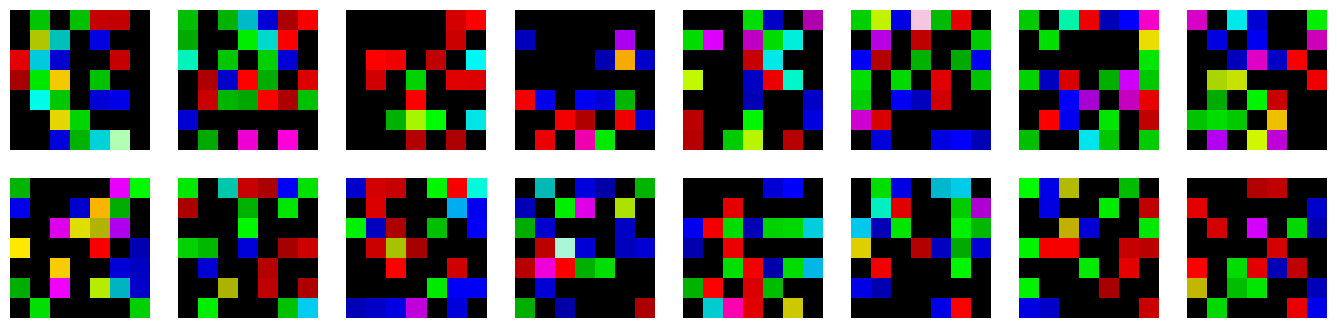

In [ ]:
get_pruned_conv('weight')

### 1-D Blocks

1-D blocks of elements is equivalent to removing vectors from the convolution filters. There are several ways to chose the vectors, that will be represented below.

* `shared_weight`: this granularity is very particular as it removes individual weights from a filter, but with a pattern that is shared across all filters.

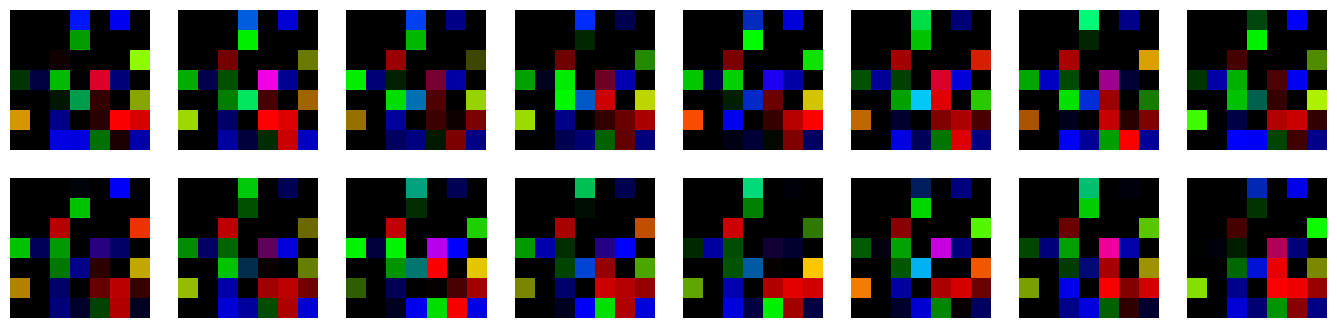

In [ ]:
get_pruned_conv('shared_weight')

* `channel`: remove vector of weights along the channel axis.

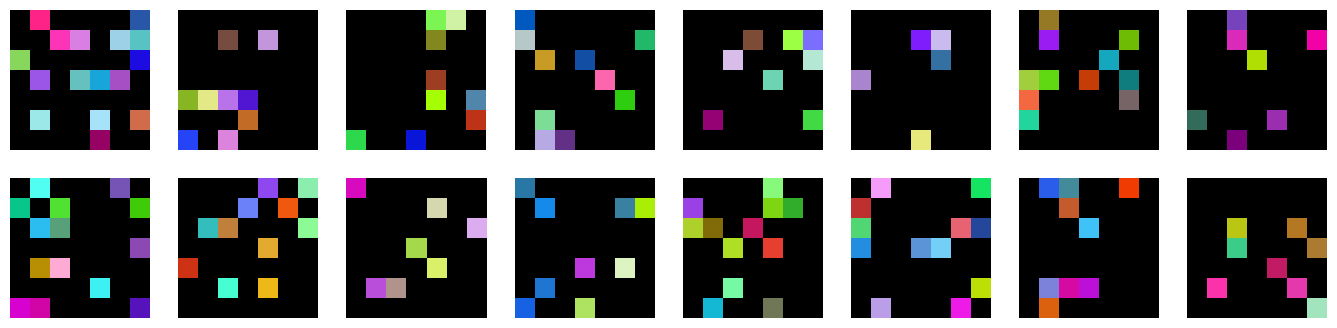

In [ ]:
get_pruned_conv('channel')

* `column`: remove vector of weights along the height axis.

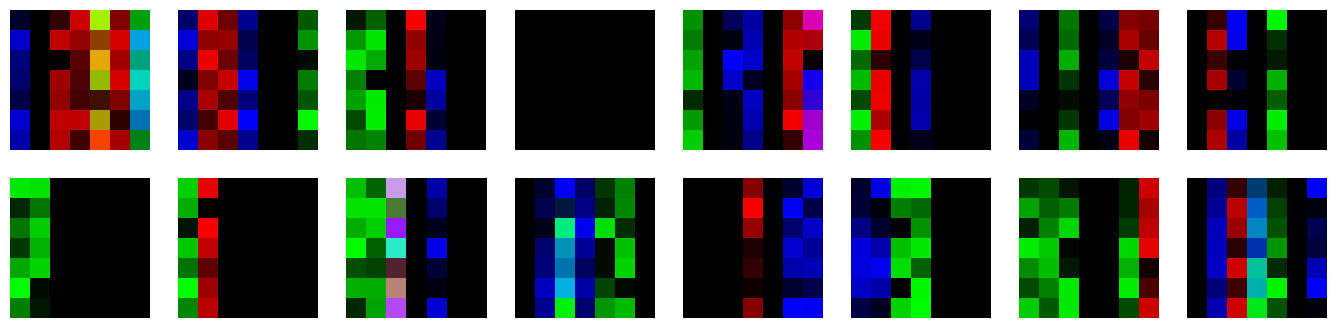

In [ ]:
get_pruned_conv('column')

* `row`: remove vector of weights along the width axis.

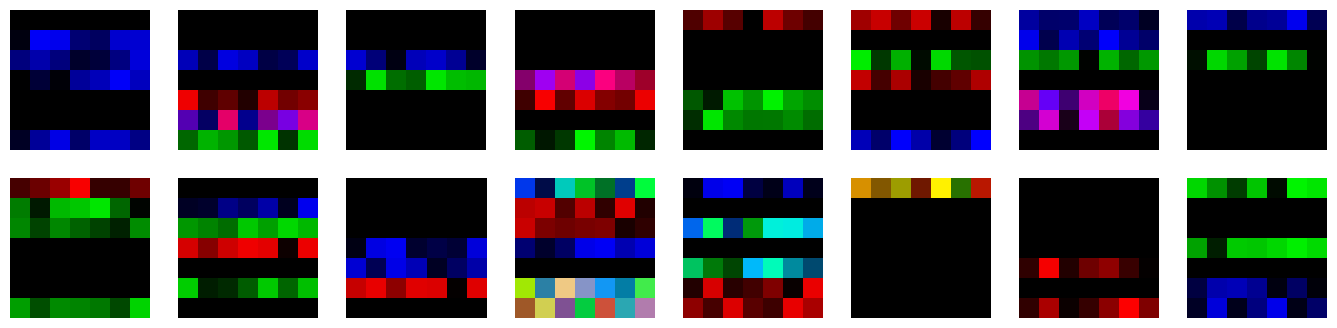

In [ ]:
get_pruned_conv('row')

### 2-D Blocks

* `shared_channel`: remove vector of weight along the channel axis, but with a pattern that is shared across all filters.

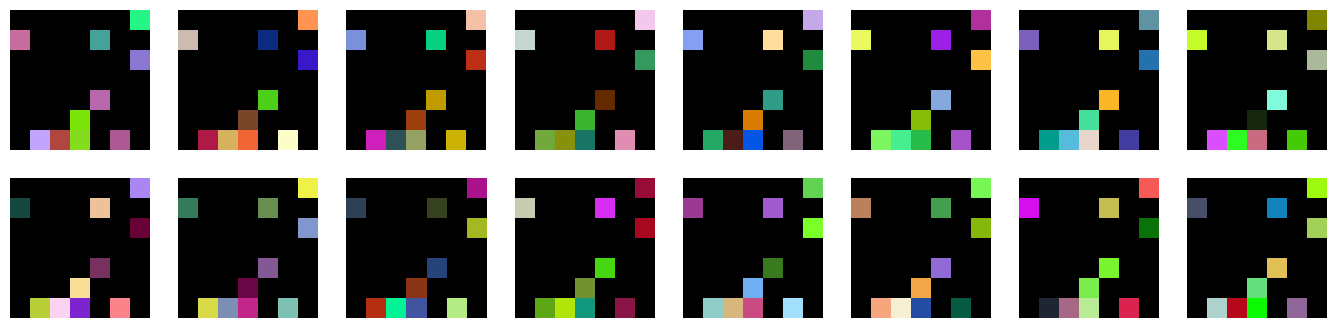

In [ ]:
get_pruned_conv('shared_channel')

* `shared_column`: remove vector of weight along the height axis, but with a pattern that is shared across all filters.

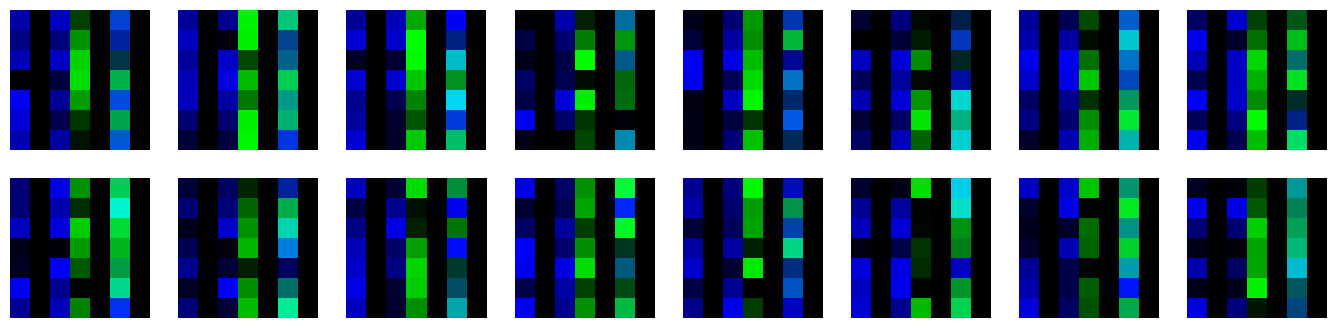

In [ ]:
get_pruned_conv('shared_column')

* `shared_row`: remove vector of weight along the width axis, but with a pattern that is shared across all filters.

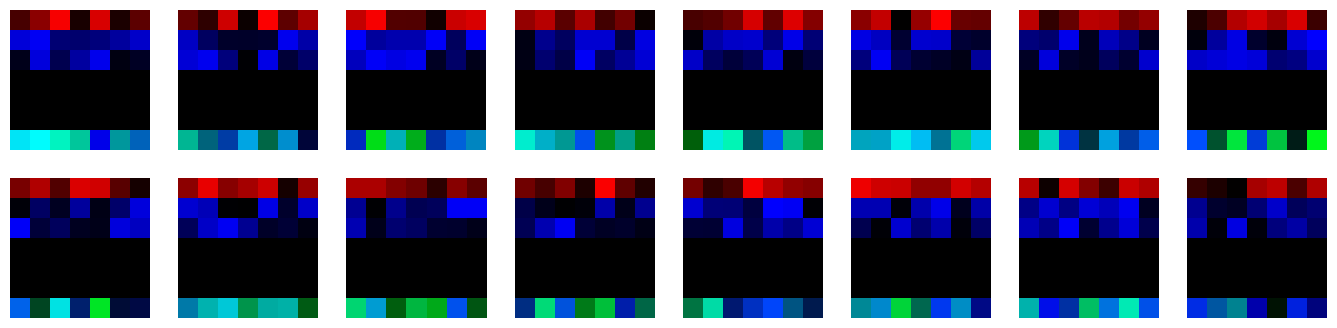

In [ ]:
get_pruned_conv('shared_row')

* `vertical_slice`: remove vertical slices of weight along the height axis.

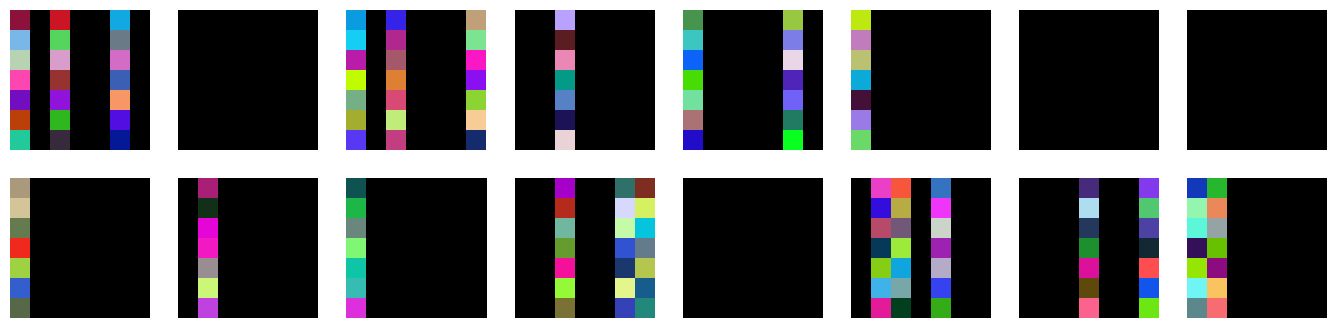

In [ ]:
get_pruned_conv('vertical_slice')

* `horizontal_slice`: remove vertical slices of weight along the width axis.

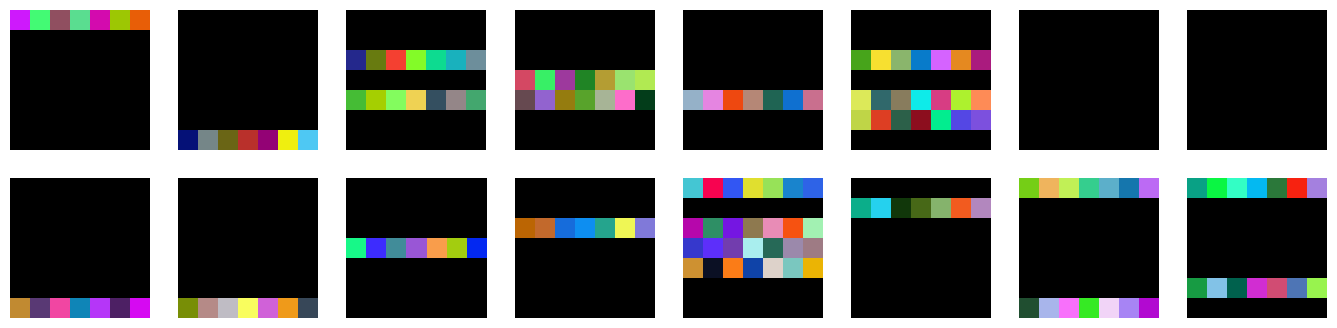

In [ ]:
get_pruned_conv('horizontal_slice')

* `kernel`: remove kernels of from the convolution filters.

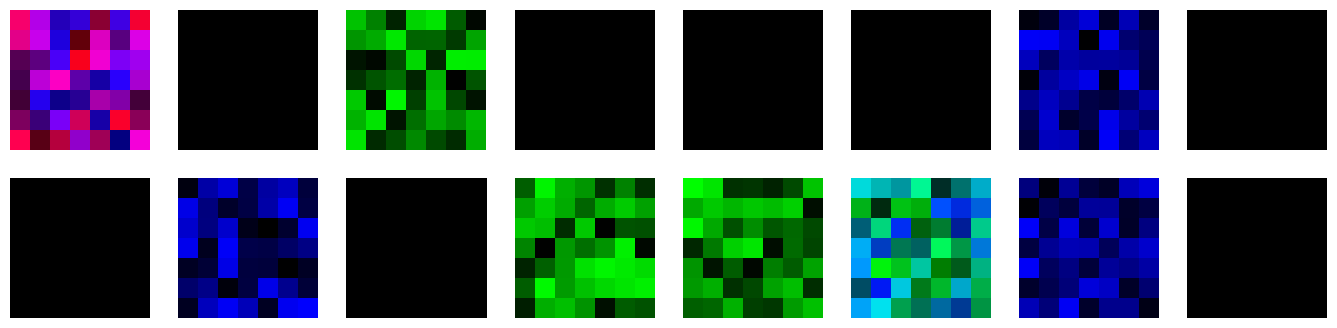

In [ ]:
get_pruned_conv('kernel')

### 3-D Blocks

* `shared_vertical_slice`: remove vertical slices of weight along the height axis, with a pattern that is shared across all filters.

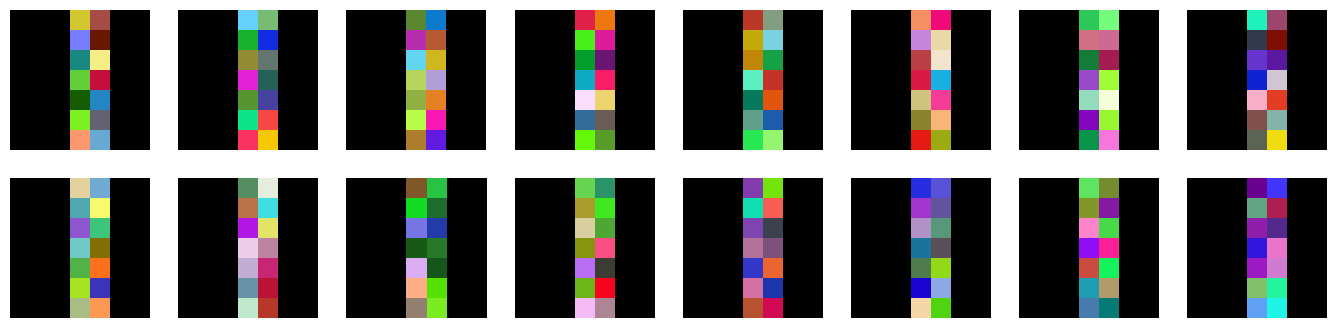

In [ ]:
get_pruned_conv('shared_vertical_slice')

* `shared_horizontal_slice`: remove horizontal slices of weight along the width axis, with a pattern that is shared across all filters.

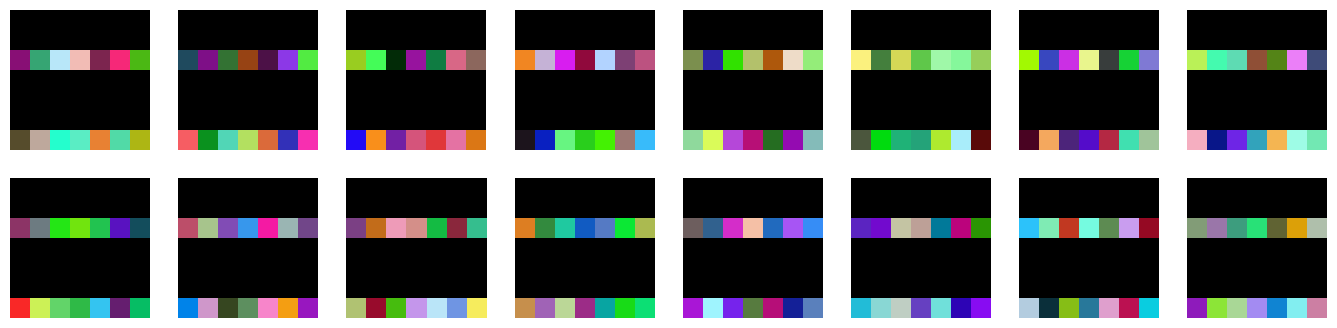

In [ ]:
get_pruned_conv('shared_horizontal_slice')

* `shared_kernel`: remove kernels of weight from the convolution filters, with a pattern that is shared across all filters.

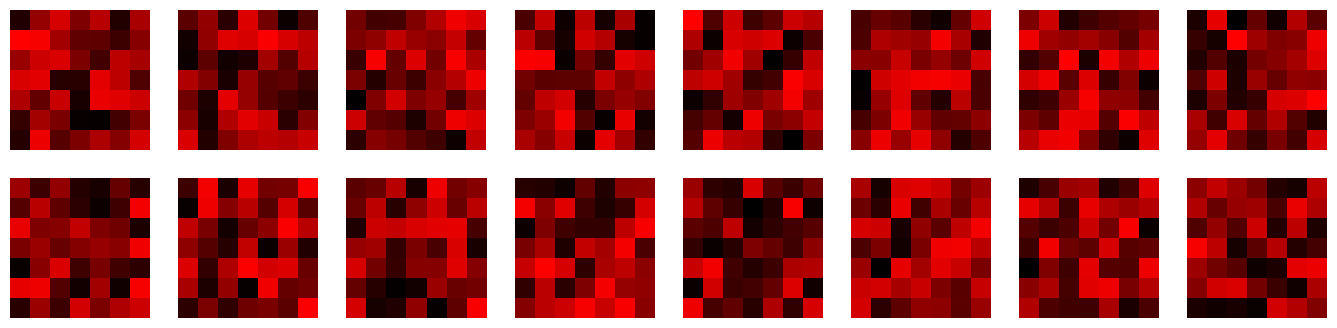

In [ ]:
get_pruned_conv('shared_kernel')

* `filter`: remove entire filters.

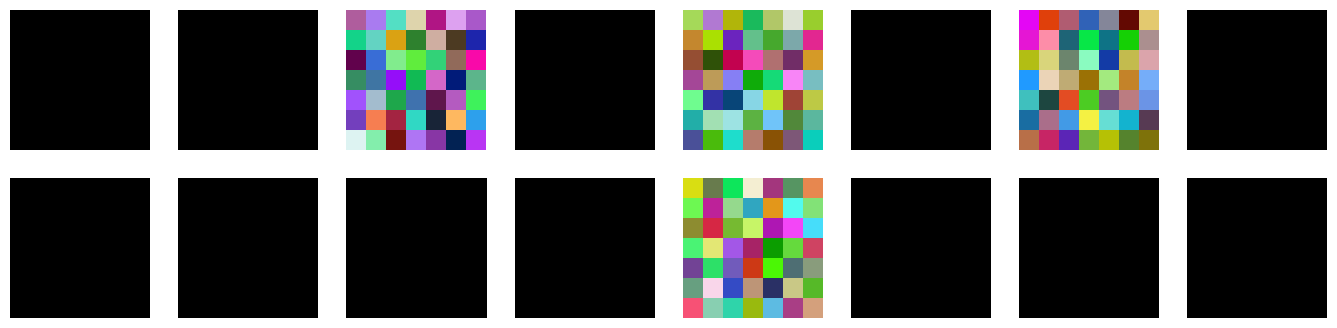

In [ ]:
get_pruned_conv('filter')

## Linear Pruning

In [ ]:
#| export
_granularities_Linear = {'weight':0, 'column':1, 'row':2, 'layer':(1,2)}

In [ ]:
#| include: false
def get_pruned_linear(granularity):
    dim = _granularities_Linear[granularity]
    lin = nn.Linear(32,16)
    pruned_weights = lin.weight[None].mean(dim=dim, keepdim=True).squeeze(0)
    threshold = torch.quantile(pruned_weights.view(-1), 0.8)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    plot_matrix(lin.weight.data.mul_(mask))

In [ ]:
#| include: false
def plot_matrix(weights, save=None):
    kernels = abs(weights)
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    img = make_grid(kernels, nrow=8, padding=1, pad_value=1)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

### 0-D Blocks

As for the convolution filters, weights from a Linear layer can be removed independently.

* `weight`: remove individual weights.

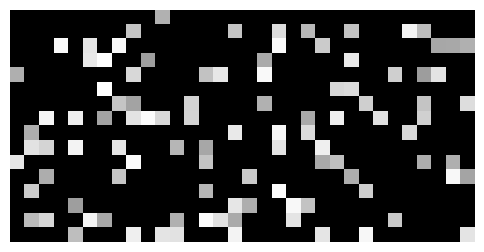

In [ ]:
get_pruned_linear('weight')

### 1-D Blocks

* `column`: remove column of weight, which corresponds to removing input neurons.

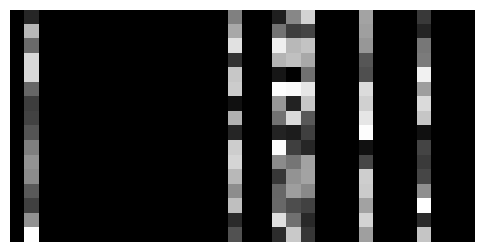

In [ ]:
get_pruned_linear('column')

* `row`: remove rows of weight, which corresponds to removing output neurons.

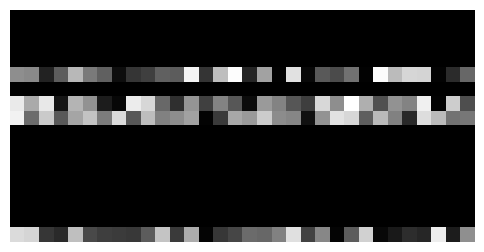

In [ ]:
get_pruned_linear('row')

## Transformer Pruning

:::{.callout-note}

This is an experimental part of the library

:::

In [ ]:
#| export
granularities = {'Conv2d': _granularities_Conv2d, 'QuantConv2d': _granularities_Conv2d , 'Linear': _granularities_Linear, 'Conv1D': _granularities_Linear}

In [ ]:
#| export
def available_granularities():
    for k in granularities.keys():
        print('Layer Type:', k)
        print('Granularities:', list(granularities[k].keys()))
        print('\n')